In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
plt.rcParams["figure.figsize"] = (16, 7)

# Overview of the data structure: 
Our main dataset [Dunnhumby - The complete journey](https://www.dunnhumby.com/careers/engineering/sourcefiles) comprises 8 csv files with the following tabular structure and content.

#### Campaign Desc
Description | Campaign ID | Start and End Day
--- | --- | ---
{TypeA, TypeB, TypeC} | int | int (probably day count from study)

#### Campaign Table
Description | Campaign ID | Household key
--- | --- | ---
{TypeA, TypeB, TypeC} | int | int

#### Causal Data
Product ID | Store ID | Week | Display location | Mailer location
--- | --- | --- | --- | --- 
int | int | int | int | String
 | | | Advertisement in in-store display? | Featured as ad in weekly mailer
 
#### Coupon Redemption
Household ID | Day | Coupon ID | Campaign ID 
--- | --- | --- | --- 
int | int | int | int 

#### Coupon
Coupon ID | Product ID | Campaign ID 
--- | --- | ---  
int | int | int 

#### Demographic
Age | Marital Status Code | Income | Homeowner | Household composition | Household size | Number of kids | Household Id
--- | --- | --- | --- | --- | --- | --- | --- |
(19-65+) | {A: Married, B: Single, U: Unknown} | | {Homeowner, Retired, etc.} | {Female/Male single, adults with/without kids, etc.} || (1-3+) |


#### Products
Product Id | Manufacturer Id | Departement  | Brand | Commodity description | Sub commodity description | Size
--- | --- | --- | --- | --- | --- | --- 
 | | {grocery, pastry, etc.} | {national/private} | | |
 
### Transaction
Household Id | Manufacturer Id | Week | Day | Time of Day | Product Id | Quantity | Sales value | Store Id | Retail discount | Coupon discount | Coupon match discount
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
 | | | | | | | What the shop actually gets | | | Loyalty program of retailer | Shop does not get price before discount | Shop does get price before discount


# Loading the data

Let's start by loading the data in pandas dataframes.

## Causal data

In [3]:
df_causal = pd.read_csv('dunnhumby/causal_data.csv')

In [4]:
df_causal.head()

,PRODUCT_ID,STORE_ID,WEEK_NO,display,mailer
0,26190,286,70,0,A
1,26190,288,70,0,A
2,26190,289,70,0,A
3,26190,292,70,0,A
4,26190,293,70,0,A


## Coupon redemption

In [5]:
df_coupon_redempt = pd.read_csv('dunnhumby/coupon_redempt.csv')

In [6]:
df_coupon_redempt.head()

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


Let's study how many coupons were redeemed for each campaign.

## Coupon

In [7]:
df_coupon = pd.read_csv('dunnhumby/coupon.csv')

In [8]:
df_coupon.head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


Let's add a column stating if a coupon has been redeemed or not.

In [9]:
df_coupon['REDEEMED'] = df_coupon['COUPON_UPC'].isin(df_coupon_redempt['COUPON_UPC'])
df_coupon.head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN,REDEEMED
0,10000089061,27160,4,False
1,10000089064,27754,9,True
2,10000089073,28897,12,True
3,51800009050,28919,28,True
4,52100000076,28929,25,True


## Demographics

In [10]:
marital_dict = {"A": "Married", "B": "Single", "U": "Unknown"}
household_size_dict = {"1": 1, "2": 2, "3": 3, "4": 4, "5+": 5}

In [11]:
df_demo = pd.read_csv("dunnhumby/hh_demographic.csv")

# Replace cryptic character with actual label
df_demo["married"] = df_demo["MARITAL_STATUS_CODE"].apply(
    lambda code: marital_dict[code]
)

# Create new column with numerical household size
for hh_str, hh_int in household_size_dict.items():
    df_demo["HOUSEHOLD_SIZE_DESC_numeric"] = df_demo["HOUSEHOLD_SIZE_DESC"].replace(
        hh_str, hh_int
    )
df_demo["HOUSEHOLD_SIZE_DESC_numeric"] = df_demo["HOUSEHOLD_SIZE_DESC_numeric"].astype(int)
    
df_demo

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,married,HOUSEHOLD_SIZE_DESC_numeric
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,Married,2
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,Married,2
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,Unknown,3
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,Unknown,4
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,Single,1
...,...,...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494,Unknown,2
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496,Married,3
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497,Unknown,1
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498,Unknown,2


Let's see from which age groups we have the most people

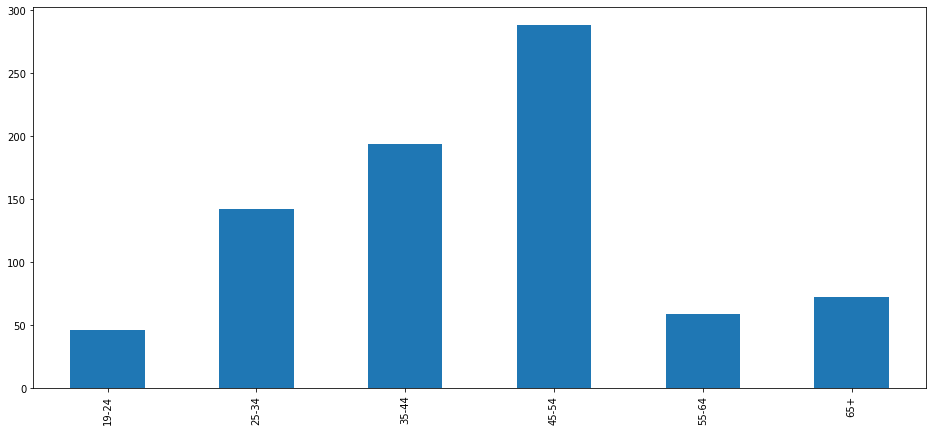

In [12]:
df_demo["AGE_DESC"].value_counts().sort_index().plot(kind="bar")
plt.show()

## Products

In [13]:
df_products = pd.read_csv('dunnhumby/product.csv')
df_products

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
...,...,...,...,...,...,...,...
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,


Let's explore the product data frame and filter out anything food related. We start by looking at the column *DEPARTMENT*.

In [14]:
list_dep = np.sort(df_products["DEPARTMENT"].unique())
list_commodity = np.sort(df_products["COMMODITY_DESC"].unique())
list_sub = np.sort(df_products["SUB_COMMODITY_DESC"].unique())

frames = {}
for l in list_dep:    
    frames[l] = df_products[df_products["DEPARTMENT"].apply(lambda x : x == l)]

In [15]:
print(df_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False))

DEPARTMENT
GROCERY            39021
DRUG GM            31529
PRODUCE             3118
COSMETICS           3011
NUTRITION           2914
MEAT                2544
MEAT-PCKGD          2427
DELI                2354
PASTRY              2149
FLORAL               938
SEAFOOD-PCKGD        563
MISC. TRANS.         490
SPIRITS              377
SEAFOOD              369
GARDEN CENTER        128
RESTAURANT           102
MISC SALES TRAN       88
SALAD BAR             48
COUP/STR & MFG        39
TRAVEL & LEISUR       28
FROZEN GROCERY        23
KIOSK-GAS             16
                      15
CHEF SHOPPE           14
RX                     9
CNTRL/STORE SUP        4
POSTAL CENTER          3
DAIRY DELI             3
TOYS                   3
VIDEO RENTAL           3
GM MERCH EXP           3
PHOTO                  2
DELI/SNACK BAR         2
PROD-WHS SALES         2
GRO BAKERY             2
CHARITABLE CONT        2
AUTOMOTIVE             2
VIDEO                  2
PORK                   1
ELECT &PLUMBIN

Let's observe the biggest categories and see whats in it.

In [16]:
frames["GROCERY"]["COMMODITY_DESC"].unique()

array(['FRZN ICE', 'FRUIT - SHELF STABLE', 'COOKIES/CONES',
       'SPICES & EXTRACTS', 'PNT BTR/JELLY/JAMS',
       'ICE CREAM/MILK/SHERBTS', 'AIR CARE', 'CHEESE', 'SHORTENING/OIL',
       'COFFEE', 'PAPER HOUSEWARES', 'BAKED BREAD/BUNS/ROLLS',
       'VEGETABLES - SHELF STABLE', 'HISPANIC', 'DINNER MXS:DRY',
       'CONDIMENTS/SAUCES', 'FRZN VEGETABLE/VEG DSH', 'BAKING NEEDS',
       'FRZN FRUITS', 'HOUSEHOLD CLEANG NEEDS', 'FD WRAPS/BAGS/TRSH BG',
       'DRY MIX DESSERTS', 'PICKLE/RELISH/PKLD VEG', 'BAKING MIXES',
       'FLUID MILK PRODUCTS', 'SOUP', 'BAKED SWEET GOODS',
       'DRY BN/VEG/POTATO/RICE', 'FACIAL TISS/DNR NAPKIN', 'FROZEN PIZZA',
       'EGGS', 'REFRGRATD DOUGH PRODUCTS', 'HOT CEREAL', 'COLD CEREAL',
       'SUGARS/SWEETNERS', 'SEAFOOD - SHELF STABLE', 'CANNED JUICES',
       'BAG SNACKS', 'BEANS - CANNED GLASS & MW', 'CRACKERS/MISC BKD FD',
       'CONVENIENT BRKFST/WHLSM SNACKS', 'SOFT DRINKS', 'BUTTER',
       'FRZN MEAT/MEAT DINNERS', 'WATER - CARBONATED/FLVRD D

As expected the category **Grocery** is all over the place and contains basically anything what can be bought in a grocery store. The category is not really helpful and we have to check the sub categories.

Lets check **Drug Gm** next and see, if there is anythin food-related in it.

In [17]:
frames["DRUG GM"]["COMMODITY_DESC"].unique()

array(['VITAMINS', 'MAGAZINE', 'DIETARY AID PRODUCTS',
       'STATIONERY & SCHOOL SUPPLIES', 'COLD AND FLU', 'BABY HBC',
       'SOAP - LIQUID & BAR', 'KITCHEN GADGETS', 'CANDY - PACKAGED',
       'HAIR CARE PRODUCTS', 'CANDY - CHECKLANE', 'SHAVING CARE PRODUCTS',
       'FIRST AID PRODUCTS', 'NEWSPAPER', 'INSECTICIDES',
       'ELECTRICAL SUPPPLIES', 'IRONING AND CHEMICALS', 'ANALGESICS',
       'HOSIERY/SOCKS', 'BATTERIES', 'BOOKSTORE',
       'SPRING/SUMMER SEASONAL', 'CHARCOAL AND LIGHTER FLUID',
       'HAND/BODY/FACIAL PRODUCTS', 'ORAL HYGIENE PRODUCTS',
       'INFANT FORMULA', 'DEODORANTS', 'FEMININE HYGIENE',
       'COFFEE FILTERS', 'BROOMS AND MOPS',
       'GREETING CARDS/WRAP/PARTY SPLY', 'HARDWARE SUPPLIES', 'ANTACIDS',
       'CIGARETTES', 'BABY FOODS', 'SINUS AND ALLERGY',
       'INFANT CARE PRODUCTS', 'TOBACCO OTHER',
       'FILM AND CAMERA PRODUCTS', 'PLASTIC HOUSEWARES',
       'FOOT CARE PRODUCTS', 'SHOE CARE', 'FIREWORKS', 'SUNTAN',
       'CANDLES/ACCESSORIES',

* 'DIETARY AID PRODUCTS' (candy bar, novelty candy, candy bags-chocolate)
* 'CANDY - PACKAGED'
* 'CANDY - CHECKLANE'
* 'INFANT FORMULA'
* 'BABY FOODS' 
* 'DOMESTIC GOODS'
* 'NATURAL HBC' (novelty candy)

After looking at the commodities individually , these do have some food related stuff in them.

In the end the following *DEPARTMENT* values are food related. There still some a lot of non food items. We have to filter them out.

In [18]:
list_dep_food = ["GROCERY", "DRUG GM", "PRODUCE", "NUTRITION", "MEAT","MEAT-PCKGD","DELI","PASTRY", "SEAFOOD-PCKGD", "SEAFOOD", 
                 "RESTAURANT", "MISC SALES TRAN", "SALAD BAR", "TRAVEL & LEISUR", "FROZEN GROCERY", "CHEF SHOPPE", "DAIRY DELI", 
                 "GM MERCH EXP", "DELI/SNACK BAR", "GRO BAKERY", "PORK", "MEAT-WHSE"]

non_food = ["COSMETICS", "FLORAL", "CHARITABLE CONT", "MISC. TRANS.", "SPIRITS", "GARDEN CENTER", 
            "COUP/STR & MFG", "KIOSK-GAS", "RX", "CNTRL/STORE SUP", "POSTAL CENTER", "TOYS", 
            "VIDEO RENTAL", "PHOTO", "PROD-WHS SALES", "CHARITABLE CONT", "AUTOMOTIVE", "VIDEO", 
            "ELECT &PLUMBING","HOUSEWARES", "PHARMACY SUPPLY", "HBC", " "]

print(list_dep_food)

['GROCERY', 'DRUG GM', 'PRODUCE', 'NUTRITION', 'MEAT', 'MEAT-PCKGD', 'DELI', 'PASTRY', 'SEAFOOD-PCKGD', 'SEAFOOD', 'RESTAURANT', 'MISC SALES TRAN', 'SALAD BAR', 'TRAVEL & LEISUR', 'FROZEN GROCERY', 'CHEF SHOPPE', 'DAIRY DELI', 'GM MERCH EXP', 'DELI/SNACK BAR', 'GRO BAKERY', 'PORK', 'MEAT-WHSE']


In [19]:
df_food_dep = df_products[df_products["DEPARTMENT"].apply(lambda x : x in list_dep_food)]
df_meat_dep = df_food_dep[df_food_dep["COMMODITY_DESC"].str.contains("MEAT")]
df_fish_dep = df_food_dep[df_food_dep["COMMODITY_DESC"].str.contains("FISH")]
np.sort(df_food_dep["COMMODITY_DESC"].unique())

array(['(CORP USE ONLY)', 'ADULT INCONTINENCE', 'AIR CARE', 'ANALGESICS',
       'ANTACIDS', 'APPAREL', 'APPLES', 'AUDIO/VIDEO PRODUCTS',
       'AUTOMOTIVE PRODUCTS', 'BABY FOODS', 'BABY HBC', 'BABYFOOD',
       'BACON', 'BAG SNACKS', 'BAKED BREAD/BUNS/ROLLS',
       'BAKED SWEET GOODS', 'BAKERY PARTY TRAYS', 'BAKING',
       'BAKING MIXES', 'BAKING NEEDS', 'BATH TISSUES', 'BATTERIES',
       'BEANS - CANNED GLASS & MW', 'BEEF', 'BEERS/ALES', 'BERRIES',
       'BEVERAGE', 'BIRD SEED', 'BLEACH', 'BOOKSTORE', 'BOTTLE DEPOSITS',
       'BREAD', 'BREAKFAST SAUSAGE/SANDWICHES', 'BREAKFAST SWEETS',
       'BROCCOLI/CAULIFLOWER', 'BROOMS AND MOPS', 'BULK FOODS', 'BUTTER',
       'CAKES', 'CANDLES/ACCESSORIES', 'CANDY - CHECKLANE',
       'CANDY - PACKAGED', 'CANNED JUICES', 'CANNED MILK', 'CARROTS',
       'CAT FOOD', 'CAT LITTER', 'CEREAL/BREAKFAST',
       'CHARCOAL AND LIGHTER FLUID', 'CHEESE', 'CHEESES', 'CHICKEN',
       'CHICKEN/POULTRY', 'CHIPS&SNACKS', 'CHRISTMAS  SEASONAL',
       '

In [20]:
list_food_com = ['APPLES', 'BABY FOODS', 'BABYFOOD',
       'BAG SNACKS', 'BAKED BREAD/BUNS/ROLLS',
       'BAKED SWEET GOODS', 'BAKERY PARTY TRAYS', 'BAKING',
       'BAKING MIXES', 'BAKING NEEDS',
       'BEANS - CANNED GLASS & MW', 'BEEF', 'BEERS/ALES', 'BERRIES',
       'BEVERAGE',
       'BREAD', 'BREAKFAST SAUSAGE/SANDWICHES', 'BREAKFAST SWEETS',
       'BROCCOLI/CAULIFLOWER', 'BULK FOODS', 'BUTTER',
       'CAKES', 'CANDY - CHECKLANE',
       'CANDY - PACKAGED', 'CANNED JUICES', 'CANNED MILK', 'CARROTS', 'CEREAL/BREAKFAST',
         'CHEESE', 'CHEESES', 'CHICKEN',
       'CHICKEN/POULTRY', 'CHIPS&SNACKS', 'CHRISTMAS  SEASONAL',
        'CITRUS', 'COCOA MIXES', 'COFFEE', 'COFFEE SHOP', 'COFFEE SHOP SWEET GOODS&RETAIL',
       'COLD CEREAL', 'CONDIMENTS', 'CONDIMENTS/SAUCES', 'CONVENIENT BRKFST/WHLSM SNACKS', 'COOKIES',
       'COOKIES/CONES', 'CORN', 'CRACKERS/MISC BKD FD', 'DELI MEATS',
       'DELI SPECIALTIES (RETAIL PK)', 'DELI SUPPLIES', 'DINNER MXS:DRY',
       'DINNER SAUSAGE', 'DOMESTIC GOODS',
       'DOMESTIC WINE', 'DRIED FRUIT', 'DRY BN/VEG/POTATO/RICE',
       'DRY MIX DESSERTS', 'DRY NOODLES/PASTA', 'DRY SAUCES/GRAVY',
       'DRY TEA/COFFEE/COCO MIX', 'EASTER', 'EGGS','EXOTIC GAME/FOWL',
       'FALL AND WINTER SEASONAL',
       'FITNESS&DIET', 'FLOUR & MEALS', 'FLUID MILK PRODUCTS', 'FROZEN',
       'FROZEN - BOXED(GROCERY)', 'FROZEN BREAD/DOUGH', 'FROZEN CHICKEN',
       'FROZEN MEAT', 'FROZEN PACKAGE MEAT', 'FROZEN PIE/DESSERTS',
       'FROZEN PIZZA', 'FRUIT - SHELF STABLE', 'FRZN BREAKFAST FOODS',
       'FRZN FRUITS', 'FRZN ICE', 'FRZN JCE CONC/DRNKS',
       'FRZN MEAT/MEAT DINNERS', 'FRZN NOVELTIES/WTR ICE',
       'FRZN POTATOES', 'FRZN SEAFOOD', 'FRZN VEGETABLE/VEG DSH', 'GRAPES',  'HEAT/SERVE', 'HERBS', 'HISPANIC',
       'HOME FREEZING & CANNING SUPPLY','HOT CEREAL', 'HOT DOGS',
        'ICE CREAM/MILK/SHERBTS',
       'IMPORTED WINE',
       'INFANT FORMULA',
       'ISOTONIC DRINKS',  'JUICE' , 'LAMB',
        'LIQUOR', 'LUNCHMEAT',
        'MARGARINES', 'MEAT - MISC', 'MEAT - SHELF STABLE',
       'MEAT SUPPLIES', 'MELONS', 'MILK BY-PRODUCTS', 'MISC WINE',
       'MISC. DAIRY', 'MISCELLANEOUS', 'MISCELLANEOUS CROUTONS',
       'MOLASSES/SYRUP/PANCAKE MIXS', 'MUSHROOMS', 'NATURAL HBC',
       'NATURAL VITAMINS', 'NDAIRY/TEAS/JUICE/SOD', 'NEW AGE',
        'NON-DAIRY BEVERAGES', 'NUTS',
       'OLIVES', 'ONIONS',
       'ORGANICS FRUIT & VEGETABLES', 
       'PACKAGED NATURAL SNACKS', 
       'PARTY TRAYS', 'PASTA SAUCE', 'PEARS', 'PEPPERS-ALL',
       'PICKLE/RELISH/PKLD VEG', 'PIES', 'PKG.SEAFOOD MISC',
        'PNT BTR/JELLY/JAMS', 'POPCORN', 'PORK',
        'POTATOES',
       'PREPARED FOOD',
       'PREPARED/PKGD FOODS', 'PROCESSED', 'PROD SUPPLIES',
       'PWDR/CRYSTL DRNK MX', 'QUICK SERVICE', 'REFRGRATD DOUGH PRODUCTS',
       'REFRGRATD JUICES/DRNKS', 'REFRIGERATED', 'RESTRICTED DIET',
       'RICE CAKES', 'ROLLS', 'RW FRESH PROCESSED MEAT', 'SALAD BAR',
       'SALAD MIX', 'SALADS/DIPS', 'SALD DRSNG/SNDWCH SPRD', 'SANDWICHES',
       'SEAFOOD - FROZEN', 'SEAFOOD - MISC', 'SEAFOOD - SHELF STABLE',
       'SEAFOOD-FRESH', 'SEASONAL', 'SERVICE BEVERAGE',  'SHORTENING/OIL',
        'SMOKED MEATS', 
       'SNACK NUTS', 'SNACKS', 'SNKS/CKYS/CRKR/CNDY', 'SOFT DRINKS', 'SOUP', 'SPICES & EXTRACTS',
       'SPORTS MEMORABLILIA', 'SPRING/SUMMER SEASONAL', 'SQUASH',
        'STONE FRUIT', 'SUGARS/SWEETNERS',
        'SUSHI', 'SWEET GOODS & SNACKS', 'SYRUPS/TOPPINGS',
       'TEAS', 'TOMATOES', 
       'TROPICAL FRUIT', 'TURKEY', 'UNKNOWN', 
       'VALUE ADDED FRUIT', 'VALUE ADDED VEGETABLES', 'VEAL',
       'VEGETABLES - ALL OTHERS', 'VEGETABLES - SHELF STABLE',
       'VEGETABLES SALAD', 'WAREHOUSE SNACKS', 'WATER',
       'WATER - CARBONATED/FLVRD DRINK', 'YOGURT']
print(list_food_com)

['APPLES', 'BABY FOODS', 'BABYFOOD', 'BAG SNACKS', 'BAKED BREAD/BUNS/ROLLS', 'BAKED SWEET GOODS', 'BAKERY PARTY TRAYS', 'BAKING', 'BAKING MIXES', 'BAKING NEEDS', 'BEANS - CANNED GLASS & MW', 'BEEF', 'BEERS/ALES', 'BERRIES', 'BEVERAGE', 'BREAD', 'BREAKFAST SAUSAGE/SANDWICHES', 'BREAKFAST SWEETS', 'BROCCOLI/CAULIFLOWER', 'BULK FOODS', 'BUTTER', 'CAKES', 'CANDY - CHECKLANE', 'CANDY - PACKAGED', 'CANNED JUICES', 'CANNED MILK', 'CARROTS', 'CEREAL/BREAKFAST', 'CHEESE', 'CHEESES', 'CHICKEN', 'CHICKEN/POULTRY', 'CHIPS&SNACKS', 'CHRISTMAS  SEASONAL', 'CITRUS', 'COCOA MIXES', 'COFFEE', 'COFFEE SHOP', 'COFFEE SHOP SWEET GOODS&RETAIL', 'COLD CEREAL', 'CONDIMENTS', 'CONDIMENTS/SAUCES', 'CONVENIENT BRKFST/WHLSM SNACKS', 'COOKIES', 'COOKIES/CONES', 'CORN', 'CRACKERS/MISC BKD FD', 'DELI MEATS', 'DELI SPECIALTIES (RETAIL PK)', 'DELI SUPPLIES', 'DINNER MXS:DRY', 'DINNER SAUSAGE', 'DOMESTIC GOODS', 'DOMESTIC WINE', 'DRIED FRUIT', 'DRY BN/VEG/POTATO/RICE', 'DRY MIX DESSERTS', 'DRY NOODLES/PASTA', 'DRY SAU

In [21]:
df_food_com = df_food_dep[df_food_dep["COMMODITY_DESC"].apply(lambda x : x in list_food_com)]

In the column *COMMODITY_DESC*, there are some categories, which are non ambigously only contain food items. But there are still categories like *BAKING NEEDS* which can contain non food items. We need to check their *SUB_COMMODITY_DESC* values for a description on the lowest level.

In [22]:
list_food_com_ambigious=['CHRISTMAS  SEASONAL', 'DOMESTIC GOODS','EASTER', 'FALL AND WINTER SEASONAL',
                         'HOME FREEZING & CANNING SUPPLY', 'NATURAL HBC', 'NATURAL VITAMINS','SEASONAL',
                         'SPORTS MEMORABLILIA', 'SPRING/SUMMER SEASONAL']

BAKING MIXES, BAKING NEEDS contains seafood?!?

Commodities to throw out (except):
* NATURAL HBC – CANDY
* NATURAL VITAMINS – PRETZELS
* SEASONAL – PUMPKINS
* SPORTS MEMORABLILIA – CANDY
* 'SPRING/SUMMER SEASONAL' – CANDY

In [23]:
df_amb_com = df_food_com[df_food_com["COMMODITY_DESC"].apply(lambda x : x in list_food_com_ambigious)]
throw_out =['MISC', 'BAKING CUPS', 'CAKE DECORS - BIRTHDAY CANDLES',
            'BANDANA/SCARVES', 'FLASHLIGHTS','AS SEEN ON TV', 'MISC BULK',
            'MISC SALES TRANS','PEYTON/GM EXPENSE ITEMS', 'MICROWAVE'] 

for amb in list_food_com_ambigious:
    for item in df_amb_com[df_amb_com["COMMODITY_DESC"].apply(lambda x : x == amb)]["SUB_COMMODITY_DESC"].unique():
        if not "CANDY" in item and not "PUMPKINS" in item and not "PRETZELS" in item:
            throw_out.append(item)


Final dataframe with only food.

In [24]:
df_food = df_food_com[df_food_com["SUB_COMMODITY_DESC"].apply(lambda x : not x in throw_out)]

df_food

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
5,26426,69,GROCERY,Private,SPICES & EXTRACTS,SPICES & SEASONINGS,2.5 OZ
...,...,...,...,...,...,...,...
92341,18272784,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,144 OZ
92342,18273018,2223,GROCERY,National,BAG SNACKS,BAGGED CHEESE SNACKS,11.5 OZ
92343,18273019,2223,GROCERY,National,BAG SNACKS,BAGGED CHEESE SNACKS,11.5 OZ
92344,18273051,436,GROCERY,National,REFRGRATD JUICES/DRNKS,DAIRY CASE CITRUS PNCH/OJ SUBS,64 OZ


In [25]:
nfoods_no_size = df_food[df_food["CURR_SIZE_OF_PRODUCT"] == " "].count()["PRODUCT_ID"]
nfoods = df_food.count()["PRODUCT_ID"]

In [26]:
print("We have size info for {:.2f}% of food products".format(100 * (1 - nfoods_no_size / nfoods)))

We have size info for 86.88% of food products


In [27]:
def filter_dataframe(df, word_list):
    filtered_df = df.copy()
    for word in word_list:
        filtered_df = filtered_df[~(filtered_df["DEPARTMENT"].str.contains(word) | filtered_df["COMMODITY_DESC"].str.contains(word) | filtered_df["SUB_COMMODITY_DESC"].str.contains(word))]
    return df[~df.index.isin(filtered_df.index)]

In [28]:
meat_list = ["MEAT","PORK", "BEEF", "DUCK", "CHICKEN", "POULTRY", "LAMB", "VEAL",
             "MUTTON", "TURKEY", "VENISON", "WILD BOAR", "BISON", "GOOSE", "RABBIT", "PHEASANT"]
seafood_list = ["HERRING", "SEAFOOD", "SEAFD","SUSHI", "FISH","SHRIMP","SALMON","TUNA",
                "TILAPIA","ALASKA","POLLOCK","PANGASIUS","BASA","SWAI","COD","CATFISH","CRAB","CLAMS"]
sweets_snack_list = ["ROLLS", "PASTRY", "NUT","CRACKERS","DESSERT","SNKS","SNACK","CHIP",
                     "CANDY", "ICE", "SWEET", "CHOCOLATE","POPCORN", "CAKE", "COOKIE", "PANCAKE",
                     "BAKING", "BAKE", "PIE"]
fruits_list = ["FRUIT","APPLE", "ORANGE", "PEAR", "BANANA", "GRAPE", "BERR", "TOMATO", "LEMON", "MELON", "PEACH", "CHERR", "PINEAPPLE", "CITRUS"]
vegetable_list = ["PUMPKIN", "COLESLAW", "SPINACH", "BEAN","VEG", "POTATO", "CARROT","CORN","PEPPER", "SQUASH", "ONION", "MUSHROOM", "CUCUMBER", "CAULIFLOWER", "BROCCOLI", "OLIVE" ]
veg_animal_list = ["DAIRY","MILK","CHEESE", "YOGURT", "BUTTER", "MARGARINE", "EGG", "HONEY"]
beverage_list = ["CIDER", "BEVERAGE", "WATER", "COKE", "FANTA", "SPRITE","LIQUOR", "LEMONADE", "COCOA", "BEER", "WINE", "COFFEE", "DRINK", "TEA", "JUICE", "DRNKS", "JCE"]
condiment_list = ["SALSA","FLOUR", "DIP","OIL","SEASONING","JELLY", "JAM","SAUCE", "HERBS", "CONDIMENT", "TOPPING", "SYRUP", "DRESSING", "KETCHUP", "MAYO", "DRSNG"]
carbs_list = ["NOODLES", "PASTA", "CROUTON","RICE", "BREAD", "TOAST", "CEREAL", "OATMEAL", "DOUGH", "POTATO"]
meal_list = ["PIZZA", "RAMEN", "SANDWICH", "SALAD","SOUP","ENTREE", "DINNER", "BREAKFAST", "THAI", "ASIAN", "ITALIAN", "MEXICAN", "GERMAN", "BURRITO", "FOOD", "ORIENTAL", "DISH"]

df_meat = filter_dataframe(df_food, meat_list)
df_seafood = filter_dataframe(df_food, seafood_list)
df_sweets_snack = filter_dataframe(df_food, sweets_snack_list)
df_fruits = filter_dataframe(df_food, fruits_list)
df_vegetable = filter_dataframe(df_food, vegetable_list)
df_veg_animal = filter_dataframe(df_food, veg_animal_list)
df_beverage = filter_dataframe(df_food, beverage_list)
df_condiments = filter_dataframe(df_food, condiment_list)
df_carbs = filter_dataframe(df_food, carbs_list)
df_meals = filter_dataframe(df_food, meal_list)
df_left = df_food[~df_food.index.isin(np.concatenate((df_meat.index,df_seafood.index, df_sweets_snack.index, df_fruits.index, df_vegetable.index, df_beverage.index, df_veg_animal.index, df_condiments.index, df_carbs.index, df_meals.index)))]

In [29]:
df_left["SUB_COMMODITY_DESC"].unique()

array(['PACKAGED MIX', 'PROCESSED OTHER', 'INFANT FORMULA TODDLER',
       'INFANT FORMULA SPECIALTY', 'CORPORATE DELETES (DO NOT USE',
       'INFANT FORMULA SOY BASE', 'DIET BARS DIET LIQUID MEALS',
       'GARLIC JAR', 'MISC DIET', 'REFRIGERATED KOSHER PRODUCTS'],
      dtype=object)

## Transaction data

In [30]:
df_transaction = pd.read_csv('dunnhumby/transaction_data.csv')

In [31]:
df_transaction.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


# Campaign analysis 

Let's start by loading the data.

In [32]:
df_campaign_desc = pd.read_csv('dunnhumby/campaign_desc.csv')
df_campaign_table = pd.read_csv('dunnhumby/campaign_table.csv')

In [33]:
df_campaign_desc.head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [34]:
df_campaign_table.head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


Let's see how many campaigns we have.

In [35]:
print('Number of campaign: ', len(df_campaign_desc.CAMPAIGN))
print('Unique description: ', df_campaign_desc.DESCRIPTION.sort_values().unique())

Number of campaign:  30
Unique description:  ['TypeA' 'TypeB' 'TypeC']


## Timespan of each campaign

We add the duration of each campaign.

In [36]:
df_campaign_desc['DURATION'] = df_campaign_desc['END_DAY'] - df_campaign_desc['START_DAY'] 
df_campaign_desc.sort_values(by = ['DESCRIPTION', 'DURATION']).head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,DURATION
29,TypeA,26,224,264,40
25,TypeA,30,323,369,46
12,TypeA,13,504,551,47
17,TypeA,8,412,460,48
7,TypeA,18,587,642,55


For each type of campaign, we compute some basic statistics.

In [37]:
for camp in ['TypeA', 'TypeB', 'TypeC']:
    print('Campaigns of %s range between %d and %d days' %(camp, df_campaign_desc[df_campaign_desc.DESCRIPTION == camp].DURATION.min(),
                                                     df_campaign_desc[df_campaign_desc.DESCRIPTION == camp].DURATION.max()))
    print('with a mean duration of %.2f days and a median duration of %.2f days.' 
            %(df_campaign_desc[df_campaign_desc.DESCRIPTION == camp].DURATION.mean(),
              df_campaign_desc[df_campaign_desc.DESCRIPTION == camp].DURATION.median()))

Campaigns of TypeA range between 40 and 55 days
with a mean duration of 47.20 days and a median duration of 47.00 days.
Campaigns of TypeB range between 32 and 61 days
with a mean duration of 37.63 days and a median duration of 32.00 days.
Campaigns of TypeC range between 32 and 161 days
with a mean duration of 74.50 days and a median duration of 64.00 days.


Let's see the different campaigns over time.

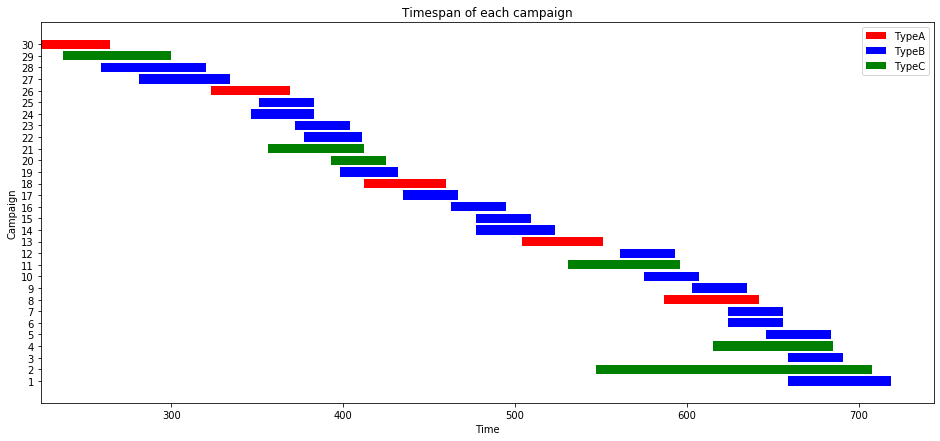

In [38]:
#Split the datas per campaign type for better visualization
beginA = df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeA']['START_DAY'].values
endA =   df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeA']['END_DAY'].values
beginB = df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeB']['START_DAY'].values
endB =   df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeB']['END_DAY'].values
beginC = df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeC']['START_DAY'].values
endC =   df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeC']['END_DAY'].values

#Plot the timespan of each campaign (note the +1 to match the indexes starting at 0 with the campaign numbers starting at 1)
plt.barh(df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeA'].index.values + 1,  endA-beginA, left=beginA, 
         color = 'red', label = 'TypeA')
plt.barh(df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeB'].index.values + 1,  endB-beginB, left=beginB, 
         color = 'blue', label = 'TypeB')
plt.barh(df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeC'].index.values + 1,  endC-beginC, left=beginC, 
         color = 'green', label = 'TypeC')

#Add title & legend
plt.title('Timespan of each campaign')
plt.ylabel('Campaign')
plt.yticks(df_campaign_desc.index + 1)
plt.xlabel('Time')
plt.legend()
plt.show()

## Number of coupons

Let's observe the distribution of the number of campaigns the households have benefited from.

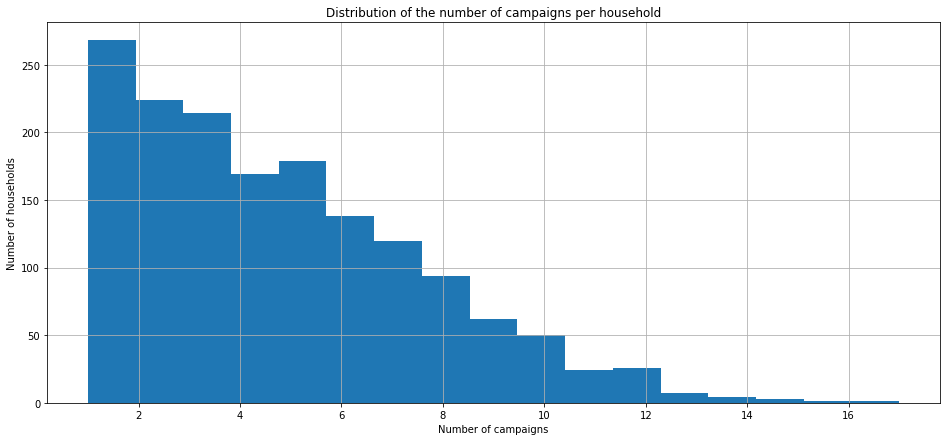

In [39]:
nbins = df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().max()
df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().hist(bins = nbins)
plt.title('Distribution of the number of campaigns per household')
plt.xlabel('Number of campaigns')
plt.ylabel('Number of households')
plt.show()

We also print some basic statistics on the number of campaigns each household has benefited from.

In [40]:
print('Mean number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().mean())
print('Median number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().median())
print('Max number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().max())
print('25% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.25),
      'campaigns or less.')
print('75% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.75),
      'campaigns or less.')
print('95% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.95),
      'campaigns or less.')

Mean number of campaigns: 4.55050505050505
Median number of campaigns: 4.0
Max number of campaigns: 17
25% of the households have benefited from 2.0 campaigns or less.
75% of the households have benefited from 6.0 campaigns or less.
95% of the households have benefited from 10.0 campaigns or less.


## Amount of coupons per campaign

We can now move to more advanced analysis. Let's start by combining this data with the coupon data.

In [41]:
df_campaign_desc.sort_values(by = 'CAMPAIGN', inplace = True)
df_campaign_desc.set_index(keys = 'CAMPAIGN', drop = True, inplace = True)
df_campaign_desc['DISTRIBUTED'] = df_coupon.groupby(by = 'CAMPAIGN').REDEEMED.count() #Number of coupons distributed
df_campaign_desc['REDEEMED'] = df_coupon[~df_coupon['REDEEMED']].groupby(by = 'CAMPAIGN').REDEEMED.count() #Number of coupons redeemed
df_campaign_desc.fillna(0, inplace = True) 
df_campaign_desc['BENEFICIARY'] = df_campaign_table.groupby(by = 'CAMPAIGN').DESCRIPTION.count() #Number of beneficiary households
df_campaign_desc.head()

,DESCRIPTION,START_DAY,END_DAY,DURATION,DISTRIBUTED,REDEEMED,BENEFICIARY
CAMPAIGN,,,,,,,
1,TypeB,346,383,37,383,363.0,13
2,TypeB,351,383,32,301,78.0,48
3,TypeC,356,412,56,740,392.0,12
4,TypeB,372,404,32,200,84.0,81
5,TypeB,377,411,34,443,97.0,166


Let's observe these results in a bar plot. For each campaign we plot the amount of coupon distributed and redeemed, and we add the type of the campaign.

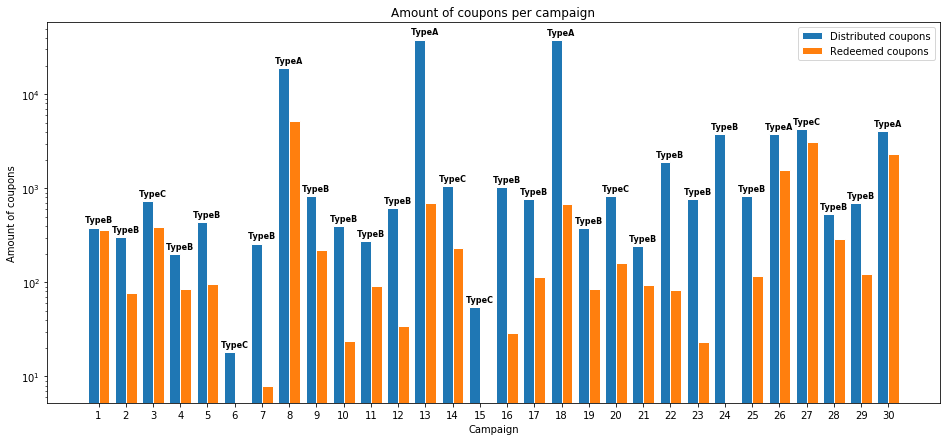

In [42]:
# set width of bar
barWidth = 0.4
 
# set height of bar
coupon_distributed = df_campaign_desc['DISTRIBUTED']
coupon_redeemed = df_campaign_desc['REDEEMED']
 
# Set position of bar on X axis
r = np.arange(len(coupon_distributed)+1)
r1 = [x - barWidth/2 for x in r[1:]]
r2 = [x + barWidth/2 for x in r[1:]]
 
# Make the plot
plt.bar(r1, coupon_distributed, width=barWidth, edgecolor='white', label='Distributed coupons')
plt.bar(r2, coupon_redeemed, width=barWidth, edgecolor='white', label='Redeemed coupons')
plt.yscale('log') #Better visualizations because very different amounts of coupon between campaign
 
# Attach a text label above each bar in *bars*, displaying the campaign type
type_c = df_campaign_desc.DESCRIPTION.values
for i in range(len(coupon_distributed.values)):    
    plt.annotate('{}'.format(type_c[i]),
                xy=(r[i+1], coupon_distributed.values[i]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontweight = 'bold',
                fontsize = 8)
  
    
# Add title and legend
plt.title('Amount of coupons per campaign')
plt.xlabel('Campaign')
plt.xticks(df_campaign_desc.index)
plt.ylabel('Amount of coupons')
plt.legend()
plt.show()

We can see the difference between the amount of coupon distributed and redeemed differs a lot from one campaign to another. It goes from cases where it is nearly null (such as campaign 1) to extreme cases where no coupons were redeemed (such as in campaigns 6, 15 and 24). To understand what happened here, we will need to inspect more precisely each campaign and join our results with data about the products and the transactions.

## Categories of coupons per campaign

To do some further analysis, we will create a function *products_categories()* taking the number of a campaign and plotting the repartition of products for which coupons were offered and were redeemed based on the categories previously defined. It will also return these 2 repartitions as dictionaries with the proportion of each category as values and the categories as keys. A parameter *show_plot* will enable to show or not the plot (if only the proportions are needed). Note that the proportions for the coupons redeemed are computed as the proportion out of the total number of coupons distributed (i.e. 20% coupons redeemed in 'meat' means that 20% of the coupons distributed were redeemed for 'meat'). This is not the same as saying that 20% of the coupons redeemed were for 'meat'.

In [43]:
# Create df with all remaining products (even non-food products)
df_left_all = df_products[
    ~df_products.index.isin(
        np.concatenate(
            (
                df_meat.index,
                df_seafood.index,
                df_sweets_snack.index,
                df_fruits.index,
                df_vegetable.index,
                df_beverage.index,
                df_veg_animal.index,
                df_condiments.index,
                df_carbs.index,
                df_meals.index,
            )
        )
    )
]

In [44]:
#Categories of food (previously defined)
categories = ['Meat', 'Seafood', 'Sweet snacks', 'Fruits', 'Vegetables', 'Veg animal', 'Beverage', 'Condiments', 'Carbs', 'Meals', 'Other']
df_list = (df_meat, df_seafood, df_sweets_snack, df_fruits, df_vegetable, 
           df_veg_animal, df_beverage, df_condiments, df_carbs, df_meals, df_left_all)

def products_categories(num_camp, show_plot = False):
    proportions_dist = dict.fromkeys(categories)
    proportions_red = dict.fromkeys(categories)
    
    #Compute the number of coupons in each category
    for categ,df in enumerate(df_list):
        #Check if coupon of a category are given for a specific campaign, otherwise simply puts 0 coupons (for coupons distributed)
        if num_camp in df.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().index:
            proportions_dist[categories[categ]] = df.merge(df_coupon, on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp][1] 
        else:
            proportions_dist[categories[categ]] = 0
        #Check if coupon of a category are given for a specific campaign, otherwise simply puts 0 coupons (for coupons redeemed)    
        if num_camp in df.merge(df_coupon[df_coupon.REDEEMED], on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().index:  
            proportions_red[categories[categ]] = df.merge(df_coupon[df_coupon.REDEEMED],
                                                          on = 'PRODUCT_ID').groupby(by = 'CAMPAIGN').count().loc[num_camp][1] 
        else:
            proportions_red[categories[categ]] = 0
    
    #Compute the proportion as percentage
        #Compute the total number of coupons distributed
    total = 0
    for i in proportions_dist.values(): 
           total += i 
    if total != 0:
        #Compute proportion of coupons distributed per category
        for key in proportions_dist.keys():
            proportions_dist[key] = 100*proportions_dist[key]/total
        #Compute proportion of coupons redeemed per category (proportion of the total number of coupons distributed)
            proportions_red[key] = 100*proportions_red[key]/total
    
    #Plot the repartitions of products for which coupons were offered
    if show_plot:   
        # set width of bar
        barWidth = 0.4
 
        # Set position of bar on X axis
        r = np.arange(len(proportions_dist))
        r1 = [x - barWidth/2 for x in r]
        r2 = [x + barWidth/2 for x in r]
 
        # Make the plot
        plt.bar(r1, list(proportions_dist.values()), width=barWidth, edgecolor='white', label='Distributed coupons')
        plt.bar(r2, list(proportions_red.values()), width=barWidth, edgecolor='white', label='Redeemed coupons')
        plt.xticks(range(len(proportions_dist)), list(proportions_dist.keys()))
        plt.title('Proportions of coupons per category during campaign ' + str(num_camp))
        plt.xlabel('Categories')
        plt.ylabel('Proportion of coupons [%]')
        plt.legend()
        plt.show()
    
    return (proportions_dist, proportions_red)

Let's see how the coupons distributed are spread over the different categories for campaign 4 for instance (a campaign mainly about sweet snacks).

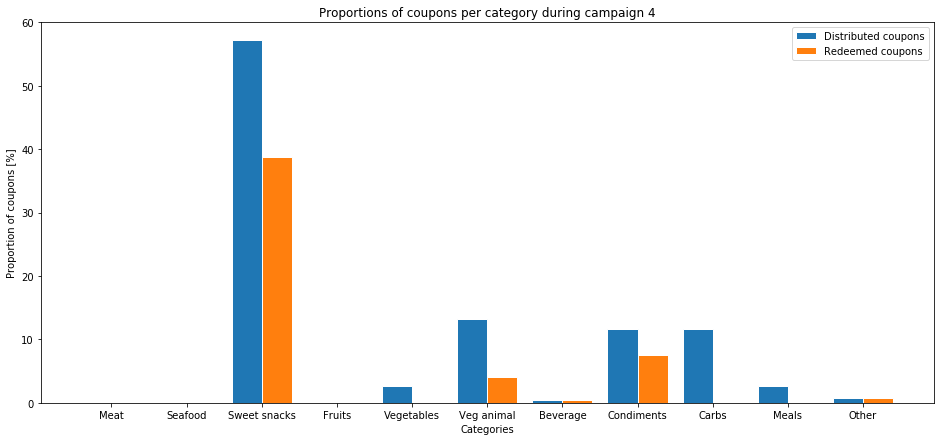

In [45]:
(prop_dist, prop_red) = products_categories(4, True)

Let's now take a more overall view, across all campaign. We will compute the proportions of coupons distributed in each category for all campaigns and plot the results in a stacked bar plot.

In [46]:
proportions_dist_overall = pd.DataFrame(columns = categories)
for i in range(30):
    proportions_dist_overall = proportions_dist_overall.append(products_categories(i+1)[0], ignore_index = True)
proportions_dist_overall.set_index(df_campaign_desc.index, inplace = True)

In [47]:
proportions_dist_overall.head()

,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other
CAMPAIGN,,,,,,,,,,,
1,7.956600,0.000000,9.945750,17.179024,17.721519,30.560579,4.339964,0.361664,0.723327,11.211573,0.000000
2,7.783418,1.522843,18.274112,0.000000,16.412860,1.015228,0.676819,0.000000,25.042301,29.272420,0.000000
3,0.319744,0.000000,7.753797,0.000000,7.673861,4.316547,3.517186,17.505995,18.944844,13.908873,26.059153
4,0.000000,0.000000,57.142857,0.000000,2.631579,13.157895,0.375940,11.654135,11.654135,2.631579,0.751880
5,0.000000,0.000000,0.436681,0.000000,0.000000,0.873362,0.436681,0.000000,2.401747,64.192140,31.659389


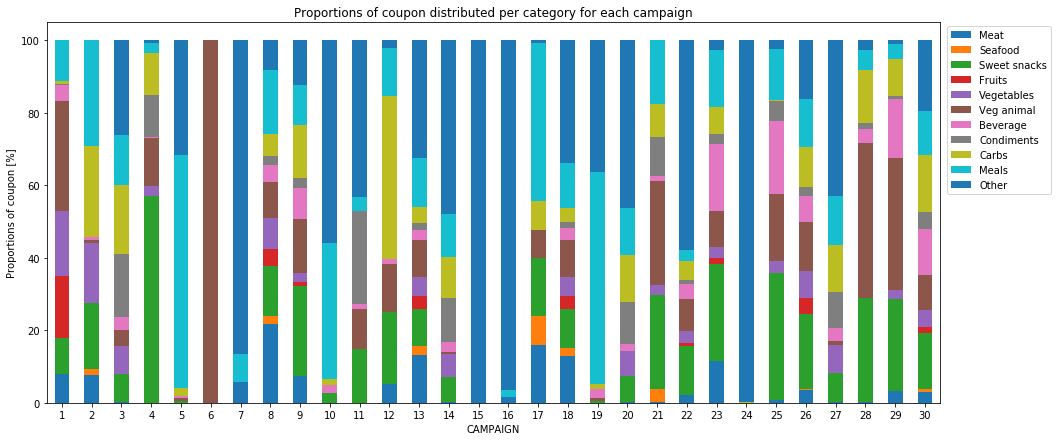

In [48]:
proportions_dist_overall.plot.bar(stacked = True)
plt.title('Proportions of coupon distributed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.13,0.77))
plt.show()

We can do the same for the proportions of coupons redeemed per category for each campaign. Note that in this case the total will not add to 100% as not all coupons are redeemed during a campaign.

In [49]:
proportions_red_overall = pd.DataFrame(columns = categories)
for i in range(30):
    proportions_red_overall = proportions_red_overall.append(products_categories(i+1)[1], ignore_index = True)
proportions_red_overall.set_index(df_campaign_desc.index, inplace = True)

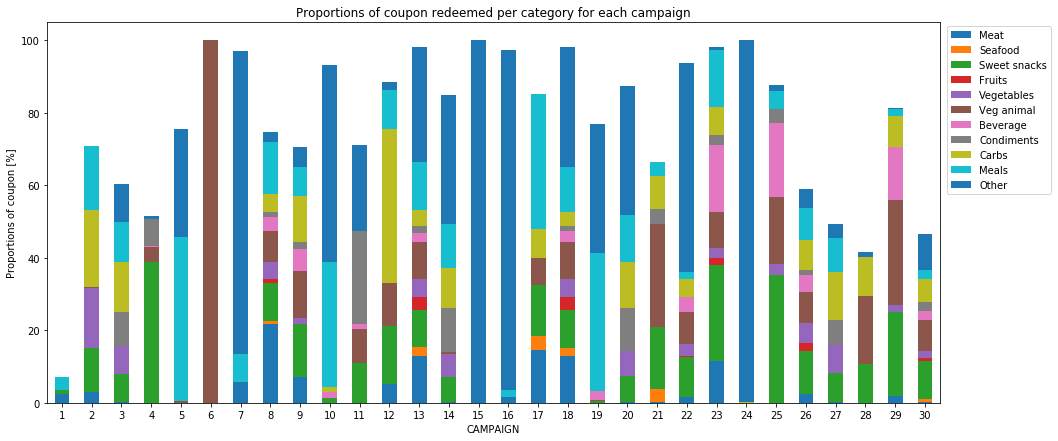

In [50]:
proportions_red_overall.plot.bar(stacked = True)
plt.title('Proportions of coupon redeemed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.13,0.77))
plt.show()

## Vegetarian vs non-vegetarian

As one can see, it is still quite hard to understand what is happening. We will thus group products in fewer categories: vegetarian, non-vegetarian, unknown and other. The 'unknown' category comprises all categories were the exact list of ingredients would be needed to know if it is vegetarian or not.

In [51]:
proportions_dist_final = pd.DataFrame()
proportions_dist_final['Vegetarian'] = proportions_dist_overall['Fruits'] + proportions_dist_overall['Vegetables'] + proportions_dist_overall['Veg animal'] + proportions_dist_overall['Carbs']
proportions_dist_final['Non-vegetarian'] = proportions_dist_overall['Meat'] + proportions_dist_overall['Seafood']
proportions_dist_final['Unknown'] = proportions_dist_overall['Sweet snacks'] + proportions_dist_overall['Beverage'] + proportions_dist_overall['Condiments'] + proportions_dist_overall['Meals']
proportions_dist_final['Other'] = proportions_dist_overall['Other']

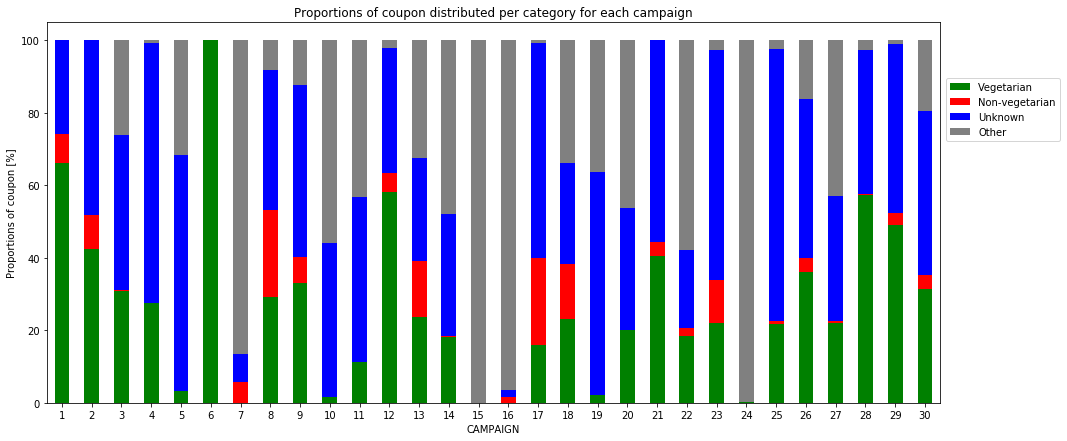

In [52]:
proportions_dist_final.plot.bar(stacked = True, color = ['green', 'red', 'blue', 'grey'])
plt.title('Proportions of coupon distributed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.14,0.77))
plt.show()

In [53]:
proportions_red_final = pd.DataFrame()
proportions_red_final['Vegetarian'] = proportions_red_overall['Fruits'] + proportions_red_overall['Vegetables'] + proportions_red_overall['Veg animal'] + proportions_red_overall['Carbs']
proportions_red_final['Non-vegetarian'] = proportions_red_overall['Meat'] + proportions_red_overall['Seafood']
proportions_red_final['Unknown'] = proportions_red_overall['Sweet snacks'] + proportions_red_overall['Beverage'] + proportions_red_overall['Condiments'] + proportions_red_overall['Meals']
proportions_red_final['Other'] = proportions_red_overall['Other']

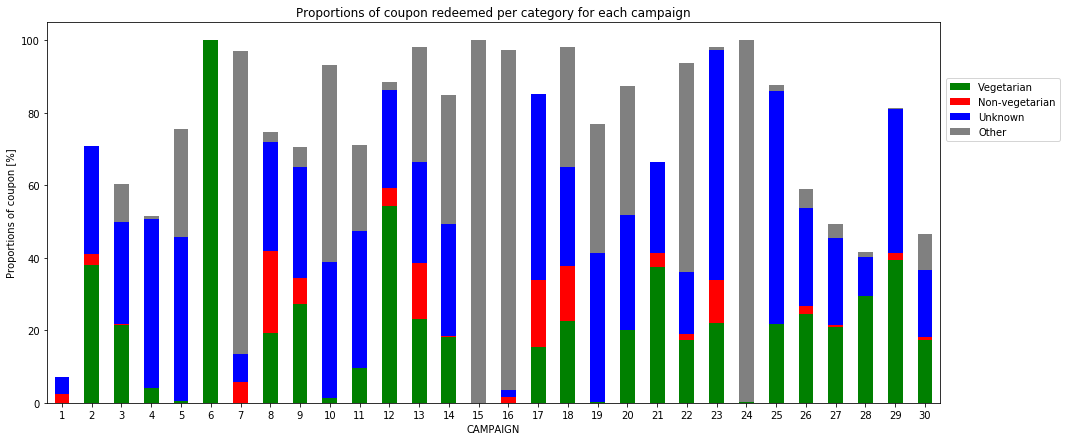

In [54]:
proportions_red_final.plot.bar(stacked = True, color = ['green', 'red', 'blue', 'grey'])
plt.title('Proportions of coupon redeemed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.14,0.77))
plt.show()

Let's have a more overall view at the vegetarian vs non-vegetarian proportions of coupons distributed and redeemed.

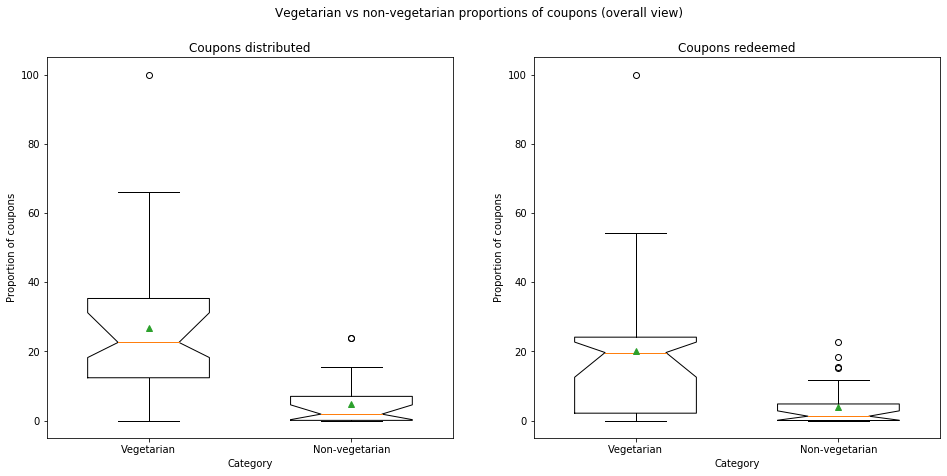

In [55]:
fig, axes = plt.subplots(1,2)

axes[0].boxplot((proportions_dist_final['Vegetarian'],proportions_dist_final['Non-vegetarian']), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showmeans = True) #Add arithmetic means as green triangle
axes[0].set_title('Coupons distributed')
axes[1].boxplot((proportions_red_final['Vegetarian'],proportions_red_final['Non-vegetarian']), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showmeans = True) #Add arithmetic means as green triangle
axes[1].set_title('Coupons redeemed')

for ax in axes:
    ax.set_xlabel('Category')
    ax.set_ylabel('Proportion of coupons')

fig.suptitle('Vegetarian vs non-vegetarian proportions of coupons (overall view)')
plt.show()

# Advertisement analysis

In [56]:
df_causal.head()

,PRODUCT_ID,STORE_ID,WEEK_NO,display,mailer
0,26190,286,70,0,A
1,26190,288,70,0,A
2,26190,289,70,0,A
3,26190,292,70,0,A
4,26190,293,70,0,A


Let's start by changing the 'display' and 'mailer' values to make them more explicit. We will define two dict and then use the map() method for this.

In [57]:
display_dict = {'0':'Not on Display', '1':'Store Front', '2':'Store Rear', '3':'Front End Cap',
                '4':'Mid-Aisle End Cap', '5':'Read End Cap', '6':'Side-Aisle End Cap', '7':'In-Aisle' ,
                '9':'Secondary Location Display' ,'A':'In-Shelf' }
mailer_dict = {'0':'Not on ad', 'A':'Interior page feature', 'C':'Interior page line item', 
              'D':'Front page feature', 'F':'Back page feature', 'H':'Wrap front feature',
              'J':'Wrap interior coupon', 'L':'Wrap back feature', 'P':'Interior page coupon',
              'X':'Free on interior page', 'Z':'Free on front page, back page or wrap'}

In [58]:
df_causal.display = df_causal.display.apply(lambda x: str(x))
df_causal.display = df_causal.display.map(display_dict, na_action = 'ignore')
df_causal.mailer = df_causal.mailer.map(mailer_dict, na_action = 'ignore')

Let's observe how many products we have in each category, both for display and mailer.

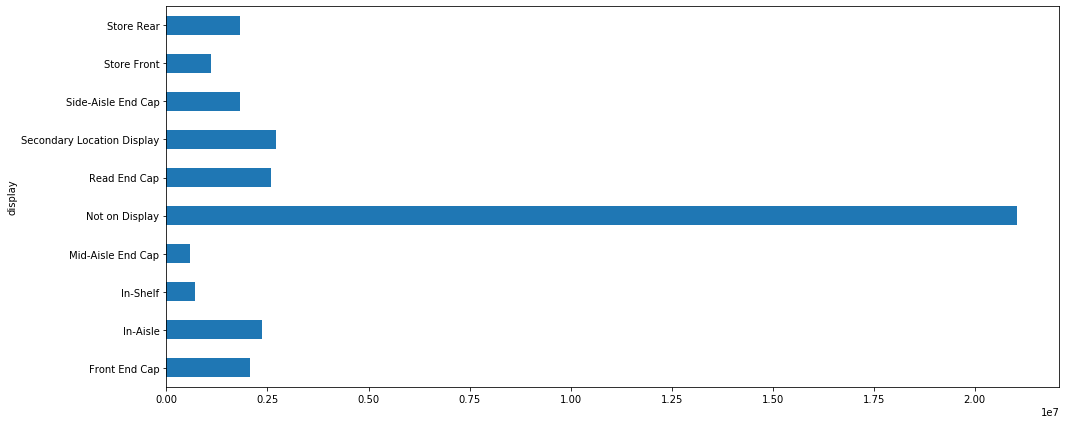

In [59]:
df_causal.groupby(by = 'display').count().mailer.plot(kind = 'barh')
plt.show()

As expected, many products are simply not in display.

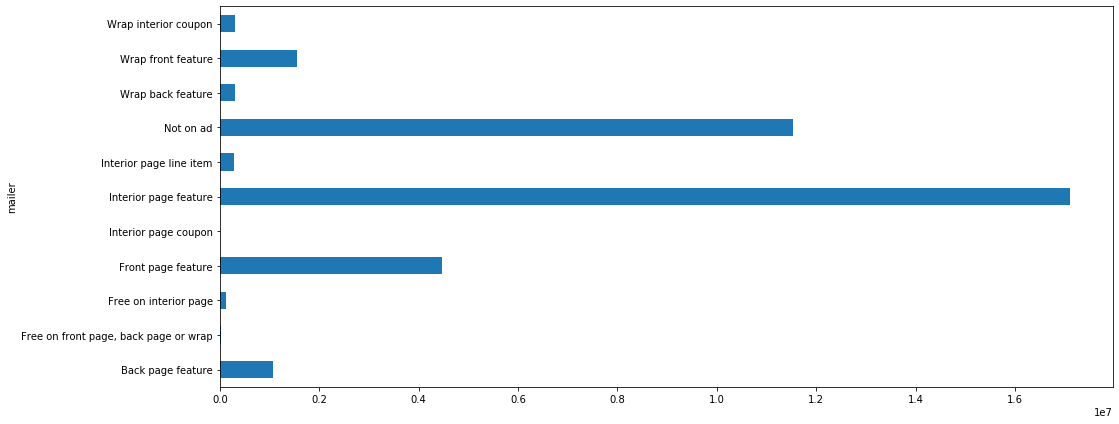

In [60]:
df_causal.groupby(by = 'mailer').count().display.plot(kind = 'barh')
plt.show()

As expected, the largest numbers of ads are in the interior or front pages.

Let's now analyse the ads distribution for each category of food previously defined. To do this, we will define a function ads_categories() that will take a dataframe (one of the 11 dataframes of the categories of food) and return the distribution of ads (as percentages). A show_plot parameter will decide if we want to directly plot the distribution in a bar plot.

In [61]:
def ads_categories(df, categ = '', show_plot = False):
    count = df.merge(df_causal, on = 'PRODUCT_ID').groupby(by = 'mailer').display.count()
    proportions = count.map(lambda x: 100*x/count.sum())
    
    if show_plot:
        proportions.plot.bar()
        plt.title('Proportion of mailer ads for %s' %categ)
        plt.xlabel('Type of ads')
        plt.xticks(rotation = 30)
        plt.ylabel('Proportion of ads [%]')
        plt.show()
    
    return (proportions,count)

Let's give an example for meat for instance.

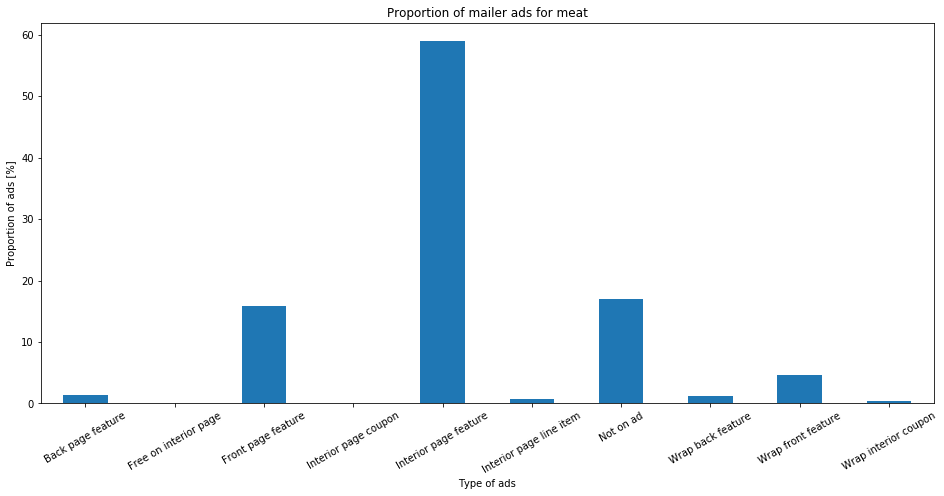

In [62]:
(prop_meat,count_meat) = ads_categories(df_meat, 'meat', True)

Let's create a dataframe to store the ads proportions for each category of food.

In [63]:
df_ads_prop = pd.DataFrame(index = mailer_dict.values(), columns = categories)
df_ads_prop.sort_index(inplace = True)
df_ads_prop.index.name = 'Type of ads'

df_ads_count = pd.DataFrame(index = mailer_dict.values(), columns = categories)
df_ads_count.sort_index(inplace = True)
df_ads_count.index.name = 'Type of ads'

In [64]:
for i,df in enumerate(df_list):
    df_ads_prop[categories[i]] = ads_categories(df)[0]
    df_ads_count[categories[i]] = ads_categories(df)[1]
df_ads_prop

,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other
Type of ads,,,,,,,,,,,
Back page feature,1.368479,0.405830,2.884632,24.799409,7.026323,1.125444,1.458132,0.825168,2.299895,3.381609,0.620899
"Free on front page, back page or wrap",NaN,NaN,0.147147,NaN,0.042866,0.263590,NaN,0.099176,NaN,0.007444,0.001585
Free on interior page,0.142373,NaN,0.425585,0.007633,0.342958,0.287262,0.699967,0.344612,0.420525,0.057125,0.184473
Front page feature,15.773294,0.903019,10.022788,5.687295,10.828357,27.474286,19.917432,1.199164,11.383607,10.343007,1.018294
Interior page coupon,0.000453,0.019763,0.000140,0.000492,0.000101,0.000068,NaN,0.000051,NaN,0.002089,0.006356
Interior page feature,58.957950,51.083917,41.362314,36.744501,44.999998,47.681953,31.909391,45.810716,47.729370,55.477674,54.399649
Interior page line item,0.664868,1.183511,1.151626,1.019288,0.500680,0.652887,0.280351,0.982150,0.811772,0.787644,0.765477
Not on ad,16.964302,37.695352,38.193379,25.657337,28.542682,15.526187,40.557356,45.572866,31.399907,22.954940,39.358097
Wrap back feature,1.174253,0.397682,1.192336,0.731779,0.503032,1.273271,0.581625,0.830781,0.338340,1.003684,0.446079


We notice some values are set to NaN. This happens because, if there are no ads of the specific type of mailer, it is simply missing from the series. We can therefore simply fill all NaN values with 0.

In [65]:
df_ads_prop.fillna(0, inplace = True)
df_ads_count.fillna(0, inplace = True)
df_ads_prop

,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other
Type of ads,,,,,,,,,,,
Back page feature,1.368479,0.405830,2.884632,24.799409,7.026323,1.125444,1.458132,0.825168,2.299895,3.381609,0.620899
"Free on front page, back page or wrap",0.000000,0.000000,0.147147,0.000000,0.042866,0.263590,0.000000,0.099176,0.000000,0.007444,0.001585
Free on interior page,0.142373,0.000000,0.425585,0.007633,0.342958,0.287262,0.699967,0.344612,0.420525,0.057125,0.184473
Front page feature,15.773294,0.903019,10.022788,5.687295,10.828357,27.474286,19.917432,1.199164,11.383607,10.343007,1.018294
Interior page coupon,0.000453,0.019763,0.000140,0.000492,0.000101,0.000068,0.000000,0.000051,0.000000,0.002089,0.006356
Interior page feature,58.957950,51.083917,41.362314,36.744501,44.999998,47.681953,31.909391,45.810716,47.729370,55.477674,54.399649
Interior page line item,0.664868,1.183511,1.151626,1.019288,0.500680,0.652887,0.280351,0.982150,0.811772,0.787644,0.765477
Not on ad,16.964302,37.695352,38.193379,25.657337,28.542682,15.526187,40.557356,45.572866,31.399907,22.954940,39.358097
Wrap back feature,1.174253,0.397682,1.192336,0.731779,0.503032,1.273271,0.581625,0.830781,0.338340,1.003684,0.446079


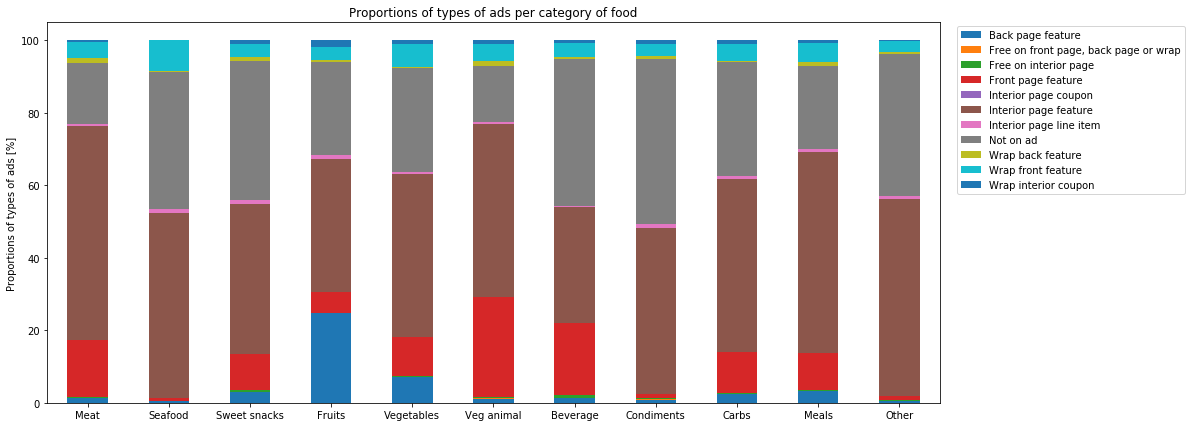

In [66]:
df_ads_prop.transpose().plot.bar(stacked = True) #The transpose() is needed to get the right kind of stacked barplot
plt.title('Proportions of types of ads per category of food')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportions of types of ads [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.28,0.77))
plt.show()

Let's look more precisely at Not on ad, Front page feature, Interior page feature and Back page feature.

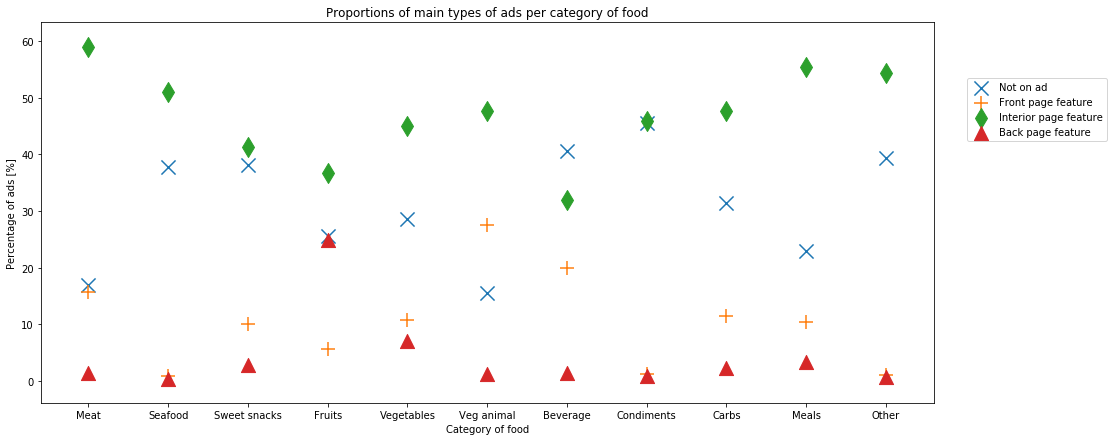

In [68]:
plt.scatter(x = range(len(categories)), y = df_ads_prop.transpose()['Not on ad'], 
            label = 'Not on ad', marker = 'x', s = 200)
plt.scatter(x = range(len(categories)), y = df_ads_prop.transpose()['Front page feature'], 
            label = 'Front page feature', marker = '+', s = 200)
plt.scatter(x = range(len(categories)), y = df_ads_prop.transpose()['Interior page feature'], 
            label = 'Interior page feature', marker = 'd', s = 200)
plt.scatter(x = range(len(categories)), y = df_ads_prop.transpose()['Back page feature'], 
            label = 'Back page feature', marker = '^', s = 200)
plt.xticks(range(len(categories)), list(categories))
plt.title('Proportions of main types of ads per category of food')
plt.xlabel('Category of food')
plt.ylabel('Percentage of ads [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.2,0.77))
plt.show()

We can see that meat ads are mainly situated in the interior pages with very few in the back pages. On the contrary, fruits have much more ads in the back pages.

# Price analysis

In this section, we will focus ourselfs on the prices of the products. We will start by some basic statistical analysis and then group products in the previously defined categories and try to extract some meaningful conclusions.

In [69]:
df_transaction = pd.read_csv('dunnhumby/transaction_data.csv')
df_transaction.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


Let's precise what does the less obvious column represent. The SALES_VALUE is the amount of dollar received by the retailer for a particular sale. The RETAIL_DISC is a discount applied due to retailer's loyalty card program. The COUPON_DISC is a discount applied due to manufacturer coupon and COUPON_MATCH_DISC a discount applied due to retailer's match of manufacturer coupon. Finally, the TRANS_TIME correspond to the time of the day the purchase was made (ranging from 0 to 2359, i.e. from 0:00 to 23:59)

In [70]:
print('We have %d transactions in our dataset.' %len(df_transaction))
print('We have %d transactions in our dataset with QUANTITY = 0.' %len(df_transaction[df_transaction.QUANTITY == 0]))

We have 2595732 transactions in our dataset.
We have 14466 transactions in our dataset with QUANTITY = 0.


We start by discarding all transcations for which the quantity is null (as no item has actually been sold in these cases).

In [71]:
df_transaction = df_transaction[df_transaction.QUANTITY > 0]
print('We have %d transactions left in our dataset.' %len(df_transaction))

We have 2581266 transactions left in our dataset.


Let's add the actual product prices (with or without loyalty card). To do so, we use the following formulas (as explained in the user guide):
- Loyalty card price = (sales_value – (retail_disc + coupon_match_disc))/quantity
- Non-loyalty card price = (sales_value – coupon_match_disc)/quantity

In [72]:
df_transaction['LOYALTY_CARD_PRICE'] = (df_transaction['SALES_VALUE'] - (df_transaction['RETAIL_DISC'] + df_transaction['COUPON_MATCH_DISC']))/df_transaction['QUANTITY']
df_transaction['NO_LOYALTY_CARD_PRICE'] = (df_transaction['SALES_VALUE'] - df_transaction['COUPON_MATCH_DISC'])/df_transaction['QUANTITY']
df_transaction.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,LOYALTY_CARD_PRICE,NO_LOYALTY_CARD_PRICE
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.99,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.82,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,1.29,0.99
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.21,1.21
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.89,1.50


## Descriptive statistics

### Sales value

In [73]:
stats.describe(df_transaction['SALES_VALUE'])

DescribeResult(nobs=2581266, minmax=(0.0, 840.0), mean=3.1215085155888613, variance=17.535166672395626, skewness=15.926605433282417, kurtosis=1347.4631439508728)

In [74]:
print('50% of the transations are below ' + str(df_transaction['SALES_VALUE'].median()) + '$.')
print('80% of the transations are below ' + str(df_transaction['SALES_VALUE'].quantile(0.8)) + '$.')
print('There are %d transactions with sales value 0.' %len(df_transaction[df_transaction['SALES_VALUE'] == 0]))

50% of the transations are below 2.0$.
80% of the transations are below 3.99$.
There are 4451 transactions with sales value 0.


### Actual price (with and without loyalty card)

In [75]:
stats.describe(df_transaction['LOYALTY_CARD_PRICE'])

DescribeResult(nobs=2581266, minmax=(0.0, 549.99), mean=2.8475153915619584, variance=9.107734563557408, skewness=17.712854891425636, kurtosis=1533.0676844073)

In [76]:
print('50% of the prices (with loyalty card) are below ' + str(df_transaction['LOYALTY_CARD_PRICE'].median()) + '$.')
print('80% of the prices (with loyalty card) are below ' + str(df_transaction['LOYALTY_CARD_PRICE'].quantile(0.8)) + '$.')

50% of the prices (with loyalty card) are below 2.19$.
80% of the prices (with loyalty card) are below 3.89$.


In [77]:
stats.describe(df_transaction['NO_LOYALTY_CARD_PRICE'])

DescribeResult(nobs=2581266, minmax=(0.0, 499.99), mean=2.4393894776524463, variance=7.401404671535539, skewness=19.48268908440757, kurtosis=1878.3518009255965)

In [78]:
print('50% of the prices (without loyalty card) are below ' + str(df_transaction['NO_LOYALTY_CARD_PRICE'].median()) + '$.')
print('80% of the prices (without loyalty card) are below ' + str(df_transaction['NO_LOYALTY_CARD_PRICE'].quantile(0.8)) + '$.')

50% of the prices (without loyalty card) are below 1.94$.
80% of the prices (without loyalty card) are below 3.27$.


### Discounts (retailer and coupons)

In [79]:
stats.describe(df_transaction['RETAIL_DISC'])

DescribeResult(nobs=2581266, minmax=(-180.0, 3.99), mean=-0.5417253742930792, variance=1.5675852595091087, skewness=-13.326902991415098, kurtosis=615.155375395817)

In [80]:
stats.describe(df_transaction['COUPON_DISC'])

DescribeResult(nobs=2581266, minmax=(-55.93, 0.0), mean=-0.012506657585851285, variance=0.028670451095912035, skewness=-49.62365938121316, kurtosis=7530.991584651517)

In [81]:
stats.describe(df_transaction['COUPON_MATCH_DISC'])

DescribeResult(nobs=2581266, minmax=(-7.7, 0.0), mean=-0.0029349203065472504, variance=0.001584079860608058, skewness=-24.366337540608725, kurtosis=1637.0498541529646)

### Transaction time

In [82]:
print('The TRANS_TIME ranges between %d and %d.' %(df_transaction['TRANS_TIME'].min(), df_transaction['TRANS_TIME'].max()))

The TRANS_TIME ranges between 0 and 2359.


## Join Food and Transaction

In [ ]:
df_food_trans = pd.merge(df_food, df_transaction, on='PRODUCT_ID', how='left')

In [ ]:
number_households = len(df_food_trans["household_key"].unique())
number_households

Let's check what percentile of the households did not buy meat and seafood products at all.

In [ ]:
df_meat_seafood = df_meat.append(df_seafood)
df_meat_seafood.drop_duplicates()

In [ ]:
df_meat_seafood_trans = pd.merge(df_meat_seafood, df_transaction, on='PRODUCT_ID', how='left')
number_household_meat_seafood = len(df_meat_seafood_trans["household_key"].unique())
print("Number of households who did not purchased any meat or seafood: % d" %(number_households-number_household_meat_seafood))

In [ ]:
weekly_meat_sea = df_meat_seafood_trans.groupby("WEEK_NO").count()["PRODUCT_ID"]
weekly_trans = df_food_trans.groupby("WEEK_NO").count()["PRODUCT_ID"]
plt.plot(weekly_meat_sea)
plt.xlabel("Week")
plt.ylabel("Number of Meat and Seafood Transactions")
plt.title("Meat and Seafood Transactions [Weekly]")
plt.show()

Overall there is no upwards or downwards trend of meat and seafood transactions. But it is weird that the meat and seafood transactions rose rapidly in the first few weeks. It is likely that in the beginning not all transactions were caught. We take a look at the relation between the number of transactions and the number of meat and seafood transactions. If the rise in the beginning is only due to the fact that not all transactions were recorded, then the relation should be linear.

In [ ]:
plt.scatter(weekly_trans, weekly_meat_sea)
plt.xlabel("Number of Transactions")
plt.ylabel("Number of Meat and Seafood Transactions")
plt.title("Meat and Seafood Transaction in Relation to overall Number of Transactions [Weekly]")
plt.show()

The relation is indeed linear.

Next we take a look at the number of households which weekly buy meat or seafood products.

In [ ]:
plt.plot(df_meat_seafood_trans.groupby("WEEK_NO")["household_key"].nunique())
plt.xlabel("Week")
plt.ylabel("Number of Households that purchased Meat or Seafood")
plt.title("Households that purchased Meat and Seafood Transactions [Weekly]")
plt.show()

The number again stays relatively stable at around 800-900. That is surprising, because the number of households which did purchase a meat product in the two years is 2475.

Let's check the number of households, which go vegetarian in a week.

In [ ]:
weekly_vege = df_food_trans.groupby("WEEK_NO")["household_key"].nunique()-df_meat_seafood_trans.groupby("WEEK_NO")["household_key"].nunique()
plt.plot(weekly_vege)
plt.xlabel("Week")
plt.ylabel("Number of Households that purchased Meat or Seafood")
plt.title("Relation of overall households and households that bought meat or seafood [Weekly]")
plt.show()

Surprisingly the number is super high considering that almost all households do not live completely vegetarian. Lets check the frequency of the meat and seafood purchases of all households.

In [ ]:
house_purchase = df_meat_seafood_trans.groupby("household_key").count()["PRODUCT_ID"]
print(house_purchase)
plt.hist(weekly_house_purchase, bins=50)
plt.xlabel("Number of meat and seafood transactions")
plt.ylabel("Frequency")
plt.title("Histrogram for Meat and SEAFOOD transaction in a household")
plt.show()

In [ ]:
house_purchase.sort_values().head(50)

Lets check the 

# Demographics and Food

Can we see if there are different buying habits for older/younger peopl? Let's start by combining our demographic data with the transactions. Then we'll annotate all transactions, if they're meat or other food.

In [83]:
df_transaction_per_household = df_transaction.merge(df_demo, on="household_key")

df_transaction_per_household["category"] = "unknown"

# First, let's mark everything that is food
df_transaction_per_household.loc[
    df_transaction_per_household["PRODUCT_ID"].isin(df_food["PRODUCT_ID"]), "category"
] = "other-food"

# Then we overwrite all entries that are actually meat
df_transaction_per_household.loc[
    df_transaction_per_household["PRODUCT_ID"].isin(df_meat["PRODUCT_ID"]), "category"
] = "meat"

df_transaction_per_household

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,...,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,married,HOUSEHOLD_SIZE_DESC_numeric,category
0,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,...,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,Single,1,other-food
1,1364,26984896261,1,897044,1,2.99,31742,-0.40,1520,1,...,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,Single,1,other-food
2,1364,26984896261,1,920955,1,3.09,31742,0.00,1520,1,...,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,Single,1,meat
3,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,...,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,Single,1,meat
4,1364,26984896261,1,981760,1,0.60,31742,-0.79,1520,1,...,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,Single,1,other-food
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419126,540,42250646707,707,9420286,2,2.00,299,-0.98,2002,102,...,25-34,B,50-74K,Homeowner,Single Female,1,None/Unknown,Single,1,other-food
1419127,540,42250646707,707,9652066,1,3.69,299,0.00,2002,102,...,25-34,B,50-74K,Homeowner,Single Female,1,None/Unknown,Single,1,other-food
1419128,540,42250646707,707,12781725,1,2.50,299,-0.49,2002,102,...,25-34,B,50-74K,Homeowner,Single Female,1,None/Unknown,Single,1,meat
1419129,540,42250646707,707,15625746,1,3.19,299,0.00,2002,102,...,25-34,B,50-74K,Homeowner,Single Female,1,None/Unknown,Single,1,other-food


Now we'll create a temporary dataframe to compute a meat ratio for each for each household. We do this by grouping by the households and then doing the calculation:

In [84]:
aa = (
    df_transaction_per_household.groupby("household_key")["category"]
    .value_counts()
    .to_frame()
    .unstack()
)

# Drop the multi-columns, so we can
# use simple indexing for ratio_meat
aa.columns = aa.columns.droplevel()

aa["ratio_meat"] = aa["meat"] / (aa["meat"] + aa["other-food"])

# Get household_key as a column
aa = aa.reset_index()

aa

category,household_key,meat,other-food,unknown,ratio_meat
0,1,145.0,1369.0,196.0,0.095773
1,7,152.0,945.0,183.0,0.138560
2,8,264.0,1392.0,311.0,0.159420
3,13,130.0,1523.0,640.0,0.078645
4,16,67.0,412.0,38.0,0.139875
...,...,...,...,...,...
796,2494,61.0,476.0,75.0,0.113594
797,2496,289.0,981.0,209.0,0.227559
798,2497,202.0,1510.0,246.0,0.117991
799,2498,62.0,662.0,135.0,0.085635


Now we combine our data to receive a new dataframe that enriches our existing demographic dataframe with a "meat ratio". This ratio tells us, how much of the bought food is considered meat.

In [85]:
# Combine our newly computed ratio_meat and the old household data
df_demo_w_meat = df_demo.merge(aa[["household_key", "ratio_meat"]], on="household_key")

# Normalize our ratio_meat by the size of the households
df_demo_w_meat["ratio_meat"] /= df_demo_w_meat["HOUSEHOLD_SIZE_DESC_numeric"]

df_demo_w_meat

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,married,HOUSEHOLD_SIZE_DESC_numeric,ratio_meat
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,Married,2,0.047886
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,Married,2,0.069280
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,Unknown,3,0.053140
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,Unknown,4,0.019661
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,Single,1,0.139875
...,...,...,...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494,Unknown,2,0.056797
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496,Married,3,0.075853
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497,Unknown,1,0.117991
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498,Unknown,2,0.042818


Now to get a sense of the data, we'll plot it. Grouped by three different attributes: marital status, age and income

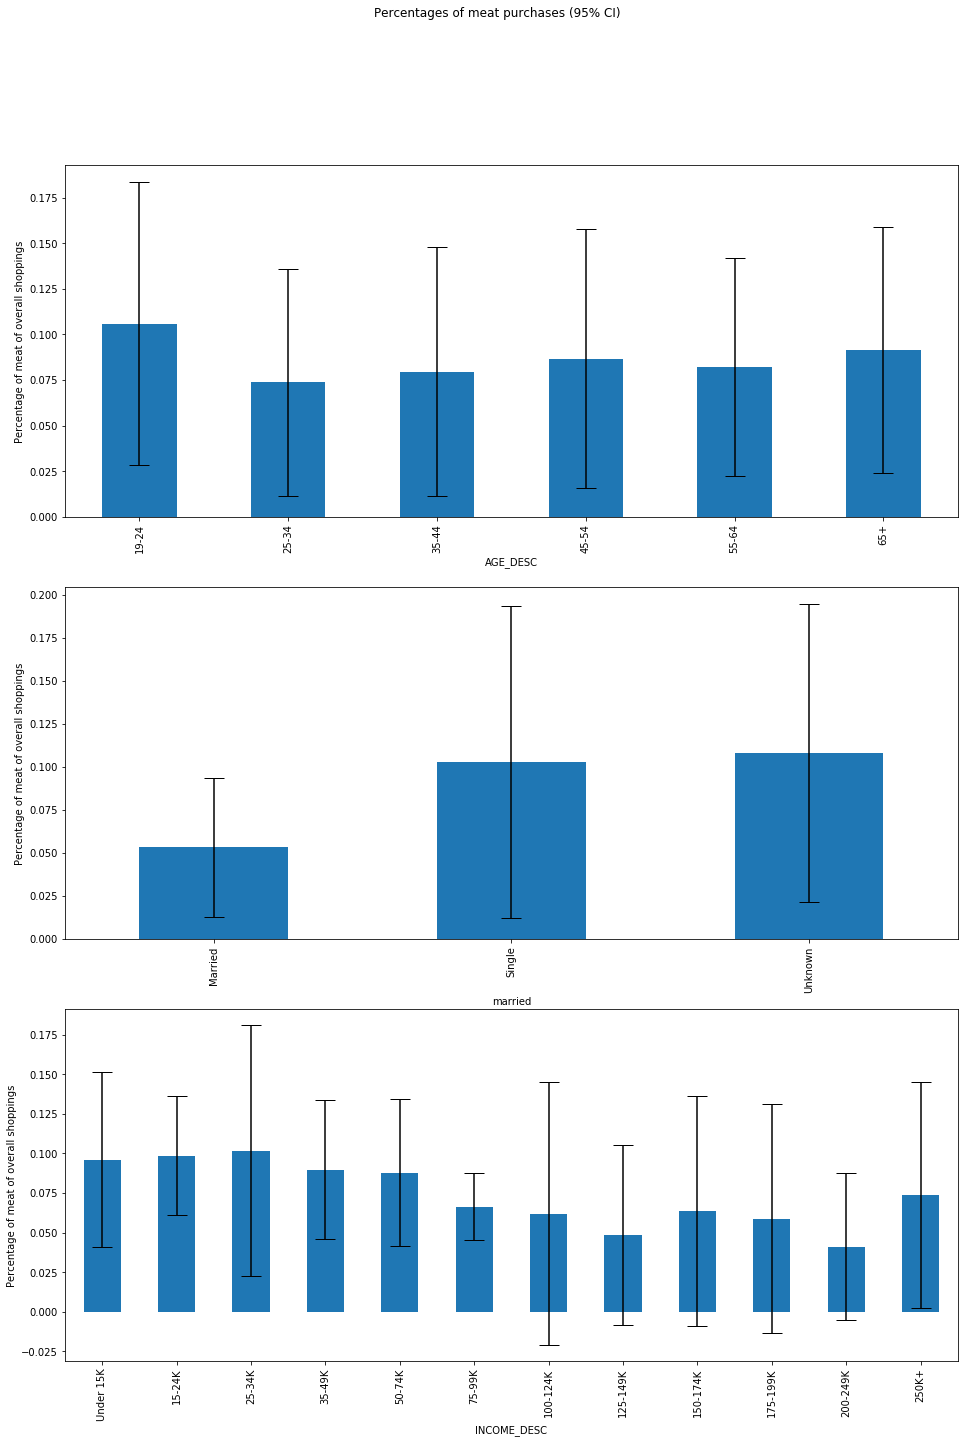

In [87]:
salary_index = [
    "Under 15K",
    "15-24K",
    "25-34K",
    "35-49K",
    "50-74K",
    "75-99K",
    "100-124K",
    "125-149K",
    "150-174K",
    "175-199K",
    "200-249K",
    "250K+",
]

fig, axes = plt.subplots(nrows=3)
interesting_groups = ["AGE_DESC", "married", "INCOME_DESC"]

for i, group_name in enumerate(interesting_groups):
    data = df_demo_w_meat.groupby(group_name).ratio_meat.mean()
    
    qupper = df_demo_w_meat.groupby(group_name).ratio_meat.quantile(0.975)
    qlower = df_demo_w_meat.groupby(group_name).ratio_meat.quantile(0.025)
    
    if group_name == "INCOME_DESC":
        data = data.reindex(salary_index)
    
    data.plot(kind="bar", ax=axes[i], yerr=[data - qlower, qupper - data], capsize=10)
    
    axes[i].set_ylabel("Percentage of meat of overall shoppings")

fig.suptitle("Percentages of meat purchases (95% CI)")
fig.set_figheight(22)
plt.show()

We see two interesting things:

- Married people seem to buy less food (might be that they buy fewer, but larger packs)
- As the income rises, the amount of meat bought decreases. It then sharply increases for incomes of over 250k